In [1]:
# @title Install dependencies
# @markdown

!pip install ipywidgets matplotlib torch torchvision tqdm hashlib requests 

# Install GNS and pyBPL
!pip install git+https://github.com/neuromatch/GNS-Modeling
!pip install git+https://github.com/neuromatch/pyBPL
!pip install numba

Defaulting to user installation because normal site-packages is not writeable
ERROR: Ignored the following yanked versions: 20081119
ERROR: Could not find a version that satisfies the requirement hashlib (from versions: none)
ERROR: No matching distribution found for hashlib

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/neuromatch/GNS-Modeling to /tmp/pip-req-build-o88w5jf6
  Running command git clone --filter=blob:none --quiet https://github.com/neuromatch/GNS-Modeling /tmp/pip-req-build-o88w5jf6
  Resolved https://github.com/neuromatch/GNS-Modeling to commit 5150c63a2d422ba2fb4b461570b6a8be8b10eea8
  Preparing metadata (setup.py) ... done
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to

In [2]:
# @title Import dependencies
# @markdown

# Standard libraries
import hashlib
import logging
import os
import random
import requests
import shutil
import time
from importlib import reload
import zipfile
from zipfile import ZipFile

# Data handling and visualization
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import io
from sklearn.model_selection import train_test_split

# Deep Learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from torchvision import transforms
from torchvision.transforms import ToPILImage

# Interactive controls in Jupyter notebooks
from IPython.display import clear_output, display
import ipywidgets as widgets

# Libraries for specific tasks related to gns and pybpl
import gns
from gns import MODEL_SAVE_PATH
from gns.inference.parsing import get_topK_parses
from gns.omniglot.classification import ClassificationDataset
from gns.rendering import Renderer as DefaultRenderer
from gns.type import TypeModel
from gns.utils.experiments import mkdir, time_string
import pybpl
from pybpl import splines, parameters
from pybpl.util import nested_map
from pybpl.util.stroke import dist_along_traj
from pybpl.util.general import fspecial

# Utility for progress bars
from tqdm import tqdm

# Reload gns 
reload(gns)

<module 'gns' from '/home/samuele/.local/lib/python3.10/site-packages/gns/__init__.py'>

In [3]:
# @title Figure settings
# @markdown

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle") 

In [4]:
# @title Plotting functions
# @markdown

def display_images(probe, options):
    # Open the probe image and the option images
    probe_image = Image.open(probe)
    option_images = [Image.open(img_path) for img_path in options]
    
    # Create a figure with the probe and the 3x3 grid for the options directly below
    fig = plt.figure(figsize=(15, 10))  # Adjust figure size as needed
    
    # Add the probe image to the top of the figure with a red border
    ax_probe = fig.add_subplot(4, 3, (1, 3))  # Span the probe across the top 3 columns
    ax_probe.imshow(probe_image)
    ax_probe.axis('off')
    rect = patches.Rectangle((0, 0), probe_image.width-1, probe_image.height-1, linewidth=2, edgecolor='r', facecolor='none')
    ax_probe.add_patch(rect)
    
    # Position the 3x3 grid of option images directly below the probe image
    for index, img in enumerate(option_images):
        row = (index // 3) + 1  # Calculate row in the 3x3 grid, starting directly below the probe
        col = (index % 3) + 1   # Calculate column in the 3x3 grid
        ax_option = fig.add_subplot(4, 3, row * 3 + col)  # Adjust grid position to directly follow the probe
        ax_option.imshow(img)
        ax_option.axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
#@title Data retrieval for zip files
# @markdown

def handle_file_operations(fname, url, expected_md5, extract_to='data'):
    """Handles downloading, verifying, and extracting a file."""
    
    # Define helper functions for download, verify, and extract operations
    def download_file(url, filename):
        """Downloads file from the given URL and saves it locally."""
        try:
            r = requests.get(url, stream=True)
            r.raise_for_status()
            with open(filename, "wb") as fid:
                for chunk in r.iter_content(chunk_size=8192):
                    fid.write(chunk)
            print("Download successful.")
            return True
        except requests.RequestException as e:
            print(f"!!! Failed to download data: {e} !!!")
            return False
    
    def verify_file_md5(filename, expected_md5):
        """Verifies the file's MD5 checksum."""
        hash_md5 = hashlib.md5()
        with open(filename, "rb") as f:
            for chunk in iter(lambda: f.read(4096), b""):
                hash_md5.update(chunk)
        if hash_md5.hexdigest() == expected_md5:
            print("MD5 checksum verified.")
            return True
        else:
            print("!!! Data download appears corrupted !!!")
            return False
    
    def extract_zip_file(filename, extract_to):
        """Extracts the ZIP file to the specified directory."""
        try:
            with zipfile.ZipFile(filename, 'r') as zip_ref:
                zip_ref.extractall(extract_to)
            print(f"File extracted successfully to {extract_to}")
        except zipfile.BadZipFile:
            print("!!! The ZIP file is corrupted or not a zip file !!!")
    
    # Main operation
    if not os.path.isfile(fname) or not verify_file_md5(fname, expected_md5):
        if download_file(url, fname) and verify_file_md5(fname, expected_md5):
            extract_zip_file(fname, extract_to)
    else:
        print(f"File '{fname}' already exists and is verified. Proceeding to extraction.")
        extract_zip_file(fname, extract_to)

# Example usage
file_info = [
    {"fname": "one-shot-classification.zip", "url": "https://osf.io/aw6eq/download", "expected_md5": "9376412e7fb74d64f045644b51e641a6"},
    {"fname": "omniglot-py.zip", "url": "https://osf.io/bazxp/download", "expected_md5": "f7a4011f5c25460c6d95ee1428e377ed"},
    {"fname": "parses.zip", "url": "https://osf.io/97bpq/download", "expected_md5": "f9e42660d860d1f95296a3729e4bd2e3"},
    {"fname": "targets.zip", "url": "https://osf.io/stk9f/download", "expected_md5": "38bbf4a87910fe56a02ee7a77a9ded3e"}
]

for file in file_info:
    handle_file_operations(**file)

#Current directory
base_dir = os.getcwd()  

MD5 checksum verified.
File 'one-shot-classification.zip' already exists and is verified. Proceeding to extraction.
File extracted successfully to data
MD5 checksum verified.
File 'omniglot-py.zip' already exists and is verified. Proceeding to extraction.
File extracted successfully to data
MD5 checksum verified.
File 'parses.zip' already exists and is verified. Proceeding to extraction.
File extracted successfully to data
MD5 checksum verified.
File 'targets.zip' already exists and is verified. Proceeding to extraction.
File extracted successfully to data


In [6]:
#@title Helper functions
# @markdown

def check_float_tesnor(x, device):
    if torch.is_tensor(x):
        assert x.shape == ()
        x = x.to(device)
    else:
        assert isinstance(x, float)
    return x
    
def drawings_to_cpu(drawings):
    if isinstance(drawings[0], list):
        if drawings[0][0].is_cuda:
            drawings = [[stk.cpu() for stk in drawing] for drawing in drawings]
    elif drawings[0].is_cuda:
        drawings = [stk.cpu() for stk in drawings]
    return drawings
    
def broaden_filter(a, b, device=None):
    H = b*torch.tensor(
        [[a/12, a/6, a/12],
         [a/6, 1-a, a/6],
         [a/12, a/6, a/12]],
        dtype=torch.get_default_dtype(),
        device=device
    )
    H = H[None, None]
    return H

def blur_filter(fsize, sigma, device=None):
    H = fspecial(fsize, sigma, ftype='gaussian', device=device)
    H = H[None,None]
    return H

def check_float_tensor(x, device):
    if torch.is_tensor(x):
        assert x.shape == ()
        x = x.to(device)
    else:
        assert isinstance(x, float)
    return x
    
def select_random_images_within_alphabet(base_path, alphabet_path, exclude_character_path, num_images=8):
    chosen_images = []
    all_characters = [char for char in os.listdir(alphabet_path) if os.path.isdir(os.path.join(alphabet_path, char)) and os.path.join(alphabet_path, char) != exclude_character_path]
    while len(chosen_images) < num_images:
        if not all_characters:
            break
        character = random.choice(all_characters)
        character_path = os.path.join(alphabet_path, character)
        all_images = [img for img in os.listdir(character_path) if img.endswith('.png')]
        if not all_images:
            continue
        image_file = random.choice(all_images)
        image_path = os.path.join(character_path, image_file)
        chosen_images.append(image_path)
    return chosen_images

def run_trial(base_path, num_trials):
    for _ in range(num_trials):
        languages = [lang for lang in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, lang))]
        selected_language = random.choice(languages)
        language_path = os.path.join(base_path, selected_language)
        characters = [char for char in os.listdir(language_path) if os.path.isdir(os.path.join(language_path, char))]
        selected_character = random.choice(characters)
        character_path = os.path.join(language_path, selected_character)
        images = [img for img in os.listdir(character_path) if img.endswith('.png')]
        probe_image_path, correct_answer_image_path = random.sample(images, 2)
        probe_image_path = os.path.join(character_path, probe_image_path)
        correct_answer_image_path = os.path.join(character_path, correct_answer_image_path)
        wrong_answers = select_random_images_within_alphabet(base_path, language_path, character_path, num_images=8)
        options = wrong_answers
        options.insert(random.randint(0, len(options)), correct_answer_image_path)
        display_images(probe_image_path, options)

In [7]:
#@title Data retrieval
# @markdown

def download_file(url, filename):
    """
    Download a file from a given URL and save it in the specified directory.
    """
    filepath = os.path.join(base_dir, filename)  # Ensure the file is saved in base_dir
    
    response = requests.get(url)
    response.raise_for_status()  # Check for HTTP request errors
    
    with open(filepath, 'wb') as f:
        f.write(response.content)

        
def verify_checksum(filename, expected_checksum):
    """
    Verify the MD5 checksum of a file

    Parameters:
    filename (str): Path to the file
    expected_checksum (str): Expected MD5 checksum

    Returns:
    bool: True if the checksum matches, False otherwise
    """
    md5 = hashlib.md5()

    with open(filename, 'rb') as f:
        for chunk in iter(lambda: f.read(4096), b""):
            md5.update(chunk)

    return md5.hexdigest() == expected_checksum

def load_models(model_files, directory, map_location='cpu'):
    """
    Load multiple models from a specified directory.
    """
    models = {}
    for model_file in model_files:
        full_path = os.path.join(directory, model_file)  # Correctly join paths
        models[model_file] = torch.load(full_path, map_location=map_location)
    return models

def verify_models_in_destination(model_files, destination_directory):
    """
    Verify the presence of model files in the specified directory.

    Parameters:
    model_files (list of str): Filenames of the models to verify.
    destination_directory (str): The directory where the models are supposed to be.

    Returns:
    bool: True if all models are found in the directory, False otherwise.
    """
    missing_files = []
    for model_file in model_files:
        # Construct the full path to where the model should be
        full_path = os.path.join(destination_directory, model_file)
        # Check if the model exists at the location
        if not os.path.exists(full_path):
            missing_files.append(model_file)

    if missing_files:
        print(f"Missing model files in destination: {missing_files}")
        return False
    else:
        print("All models are correctly located in the destination directory.")
        return True
        
# URLs and checksums for the models
models_info = {
    'location_model.pt': ('https://osf.io/zmd7y/download', 'dfd51cf7c3a277777ad941c4fcc23813'),
    'stroke_model.pt': ('https://osf.io/m6yc7/download', '511ea7bd12566245d5d11a85d5a0abb0'),
    'terminate_model.pt': ('https://osf.io/dsmhc/download', '2f3e26cfcf36ce9f9172c15d8b1079d1')
}

destination_directory = base_dir

# Define model_files based on the keys of models_info to ensure we have the filenames
model_files = list(models_info.keys())

# Iterate over the models to download and verify
for model_name, (url, checksum) in models_info.items():
    download_file(url, model_name)  # Downloads directly into base_dir
    if verify_checksum(os.path.join(base_dir, model_name), checksum):
        print(f"Successfully verified {model_name}")
    else:
        print(f"Checksum does not match for {model_name}. Download might be corrupted.")

# Verify the presence of the models in the destination directory
if verify_models_in_destination(model_files, destination_directory):
    print("Verification successful: All models are in the correct directory.")
else:
    print("Verification failed: Some models are missing from the destination directory.")

# Load the models from the destination directory
models = load_models(model_files, destination_directory, map_location='cpu')


Successfully verified location_model.pt
Successfully verified stroke_model.pt
Successfully verified terminate_model.pt
All models are correctly located in the destination directory.
Verification successful: All models are in the correct directory.


In [8]:
# Activity 1

#Students interact with a simple widget to perform the categorization task in Lake et al. (2015)

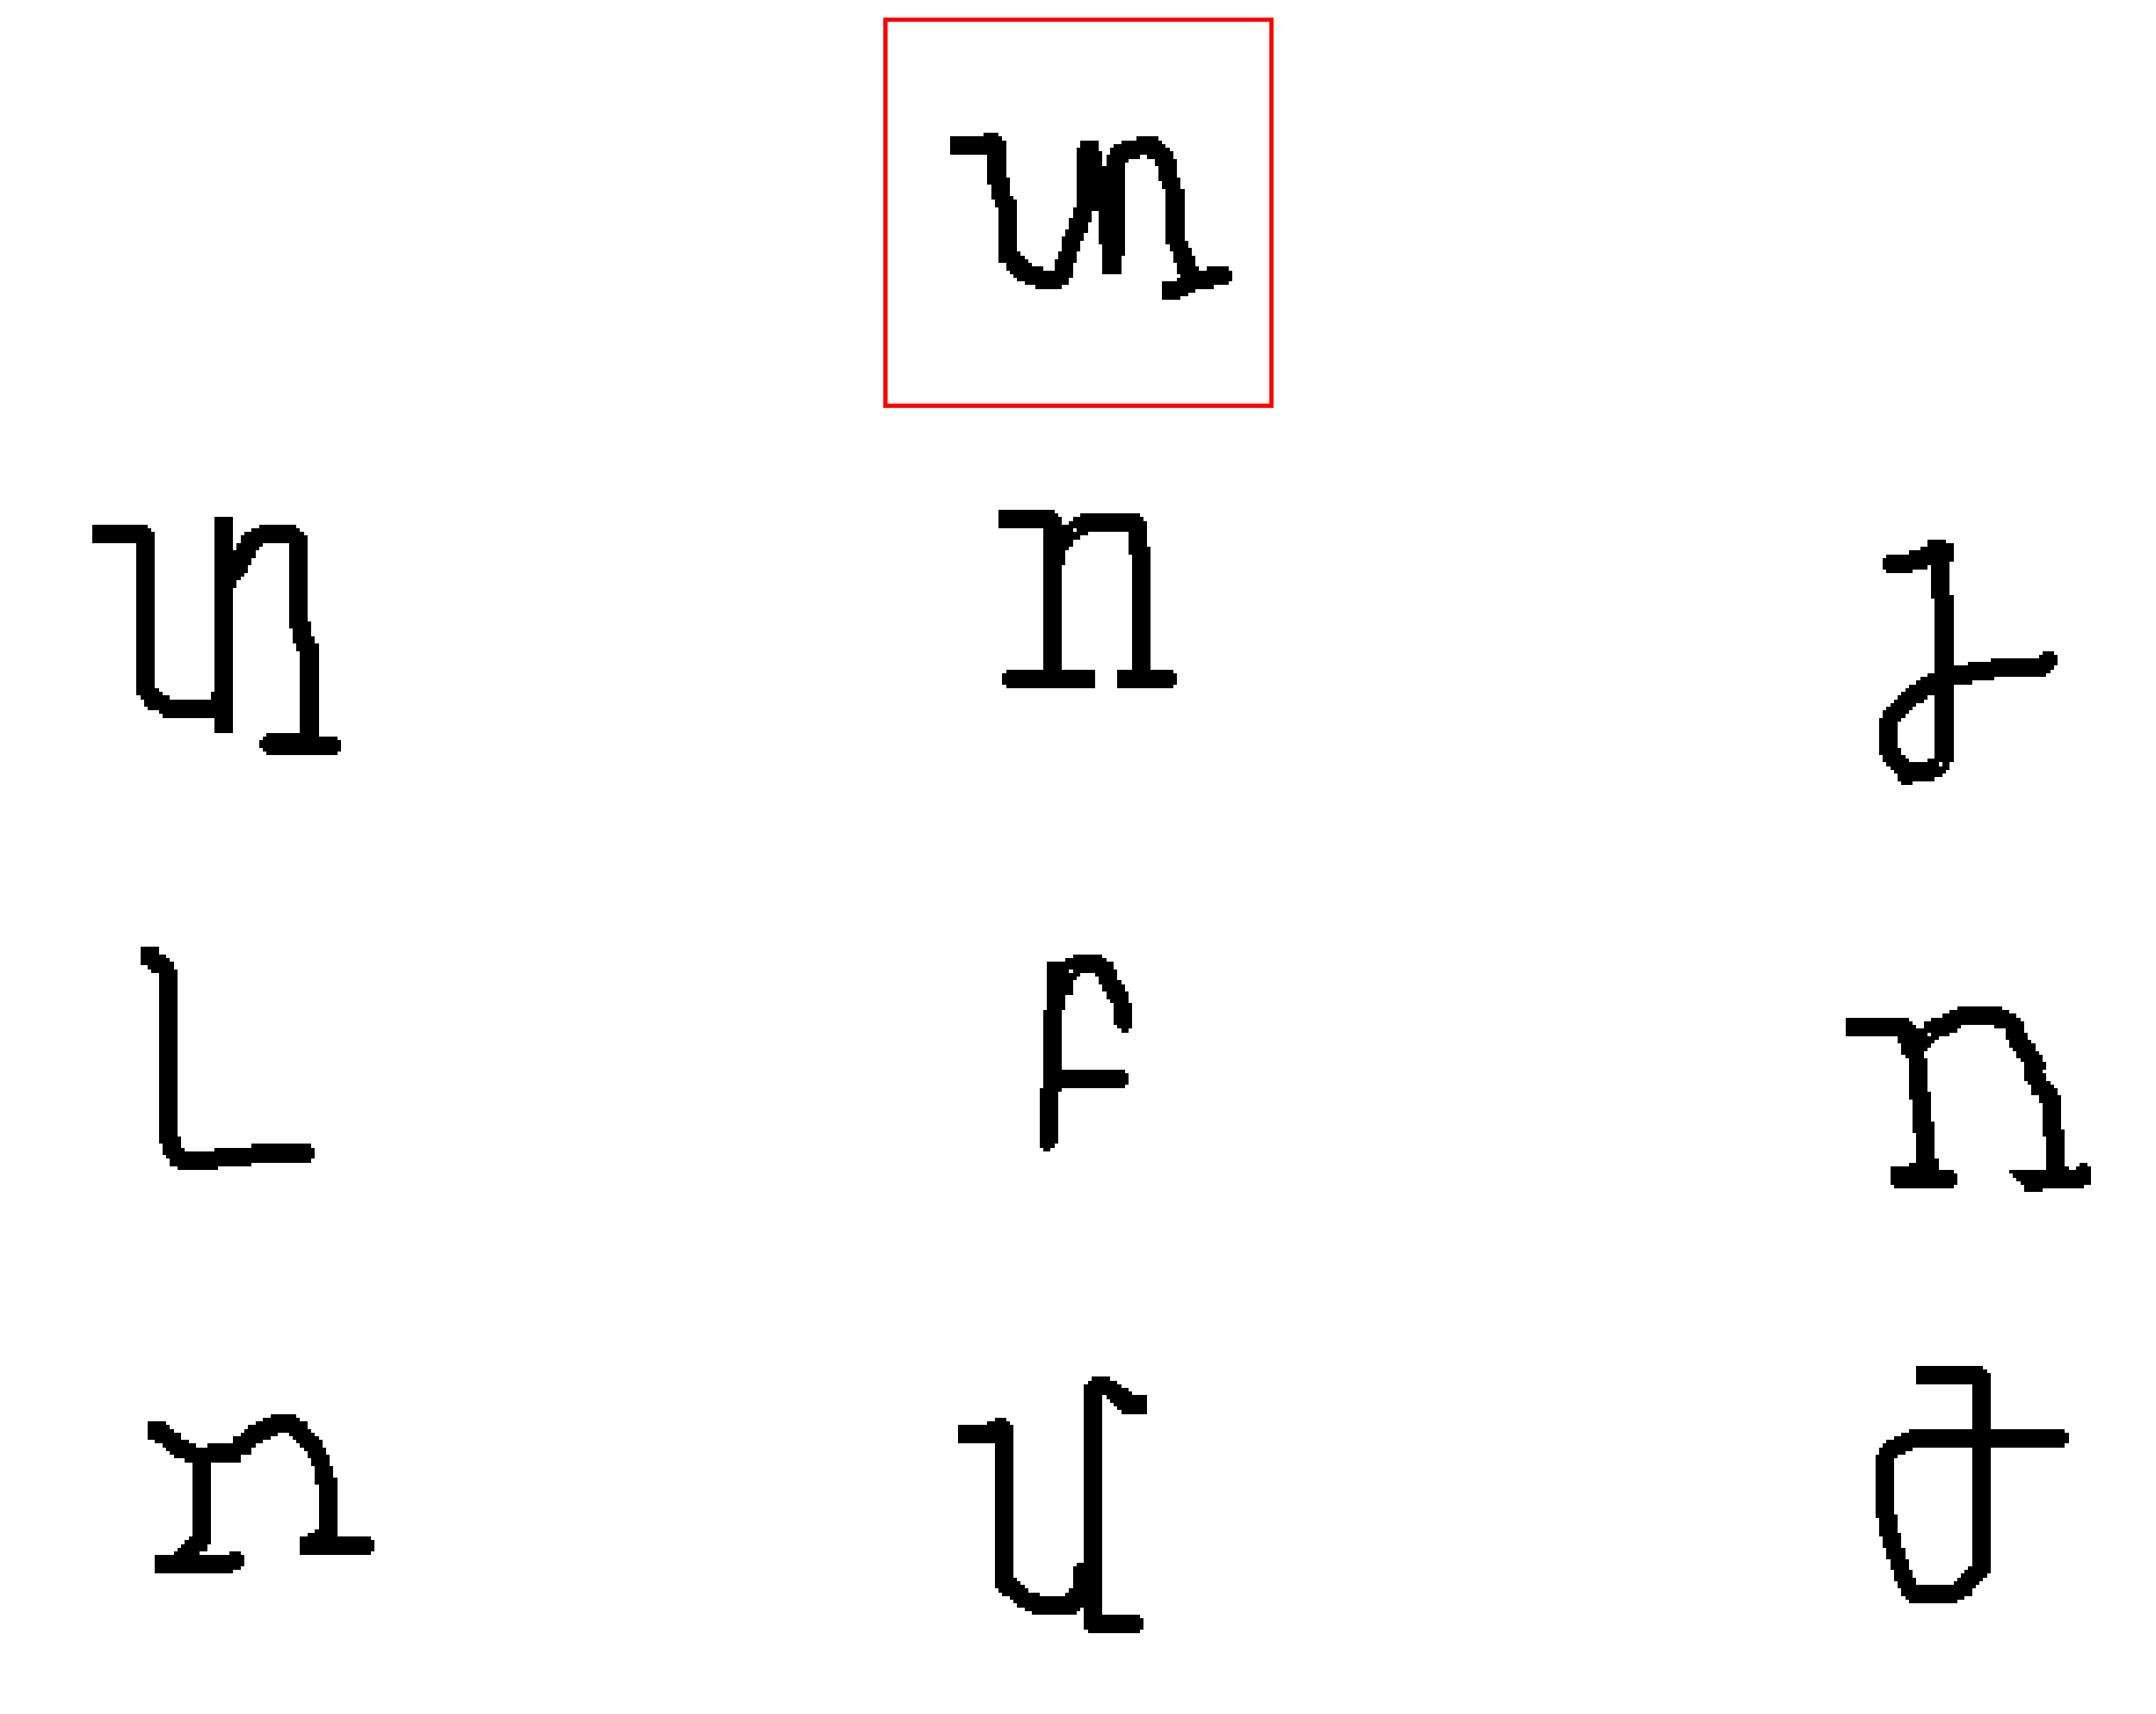

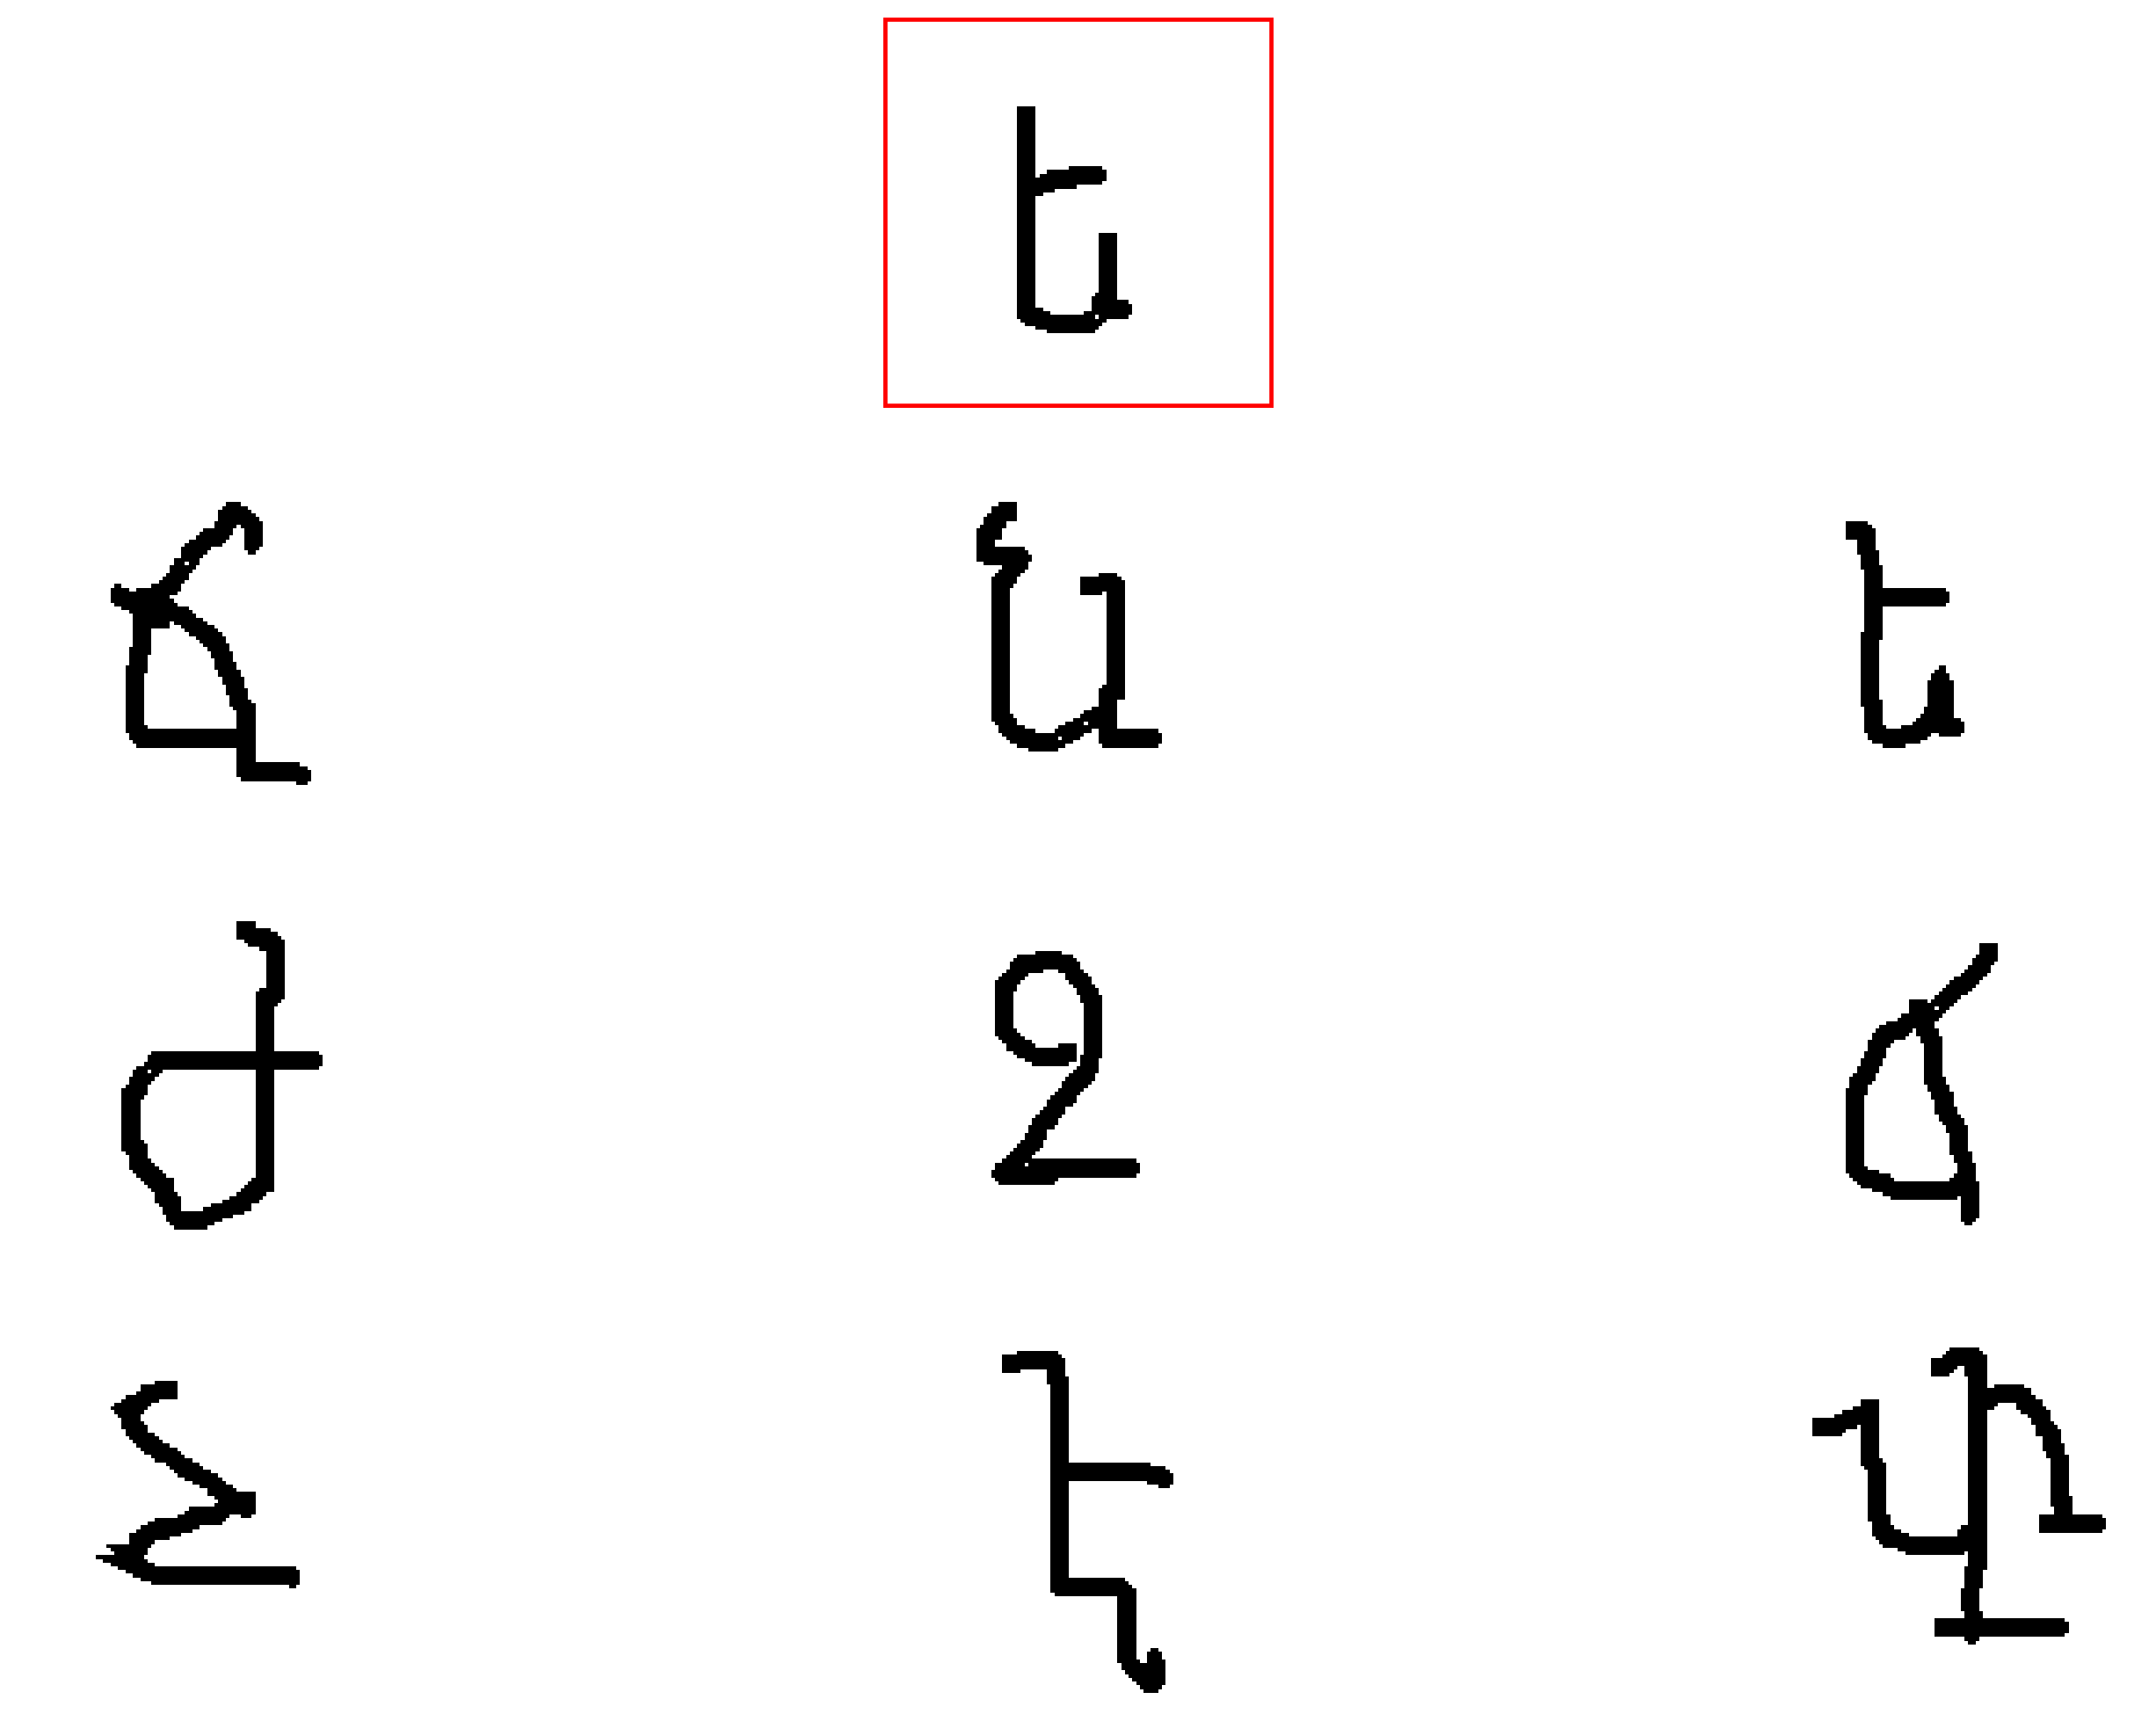

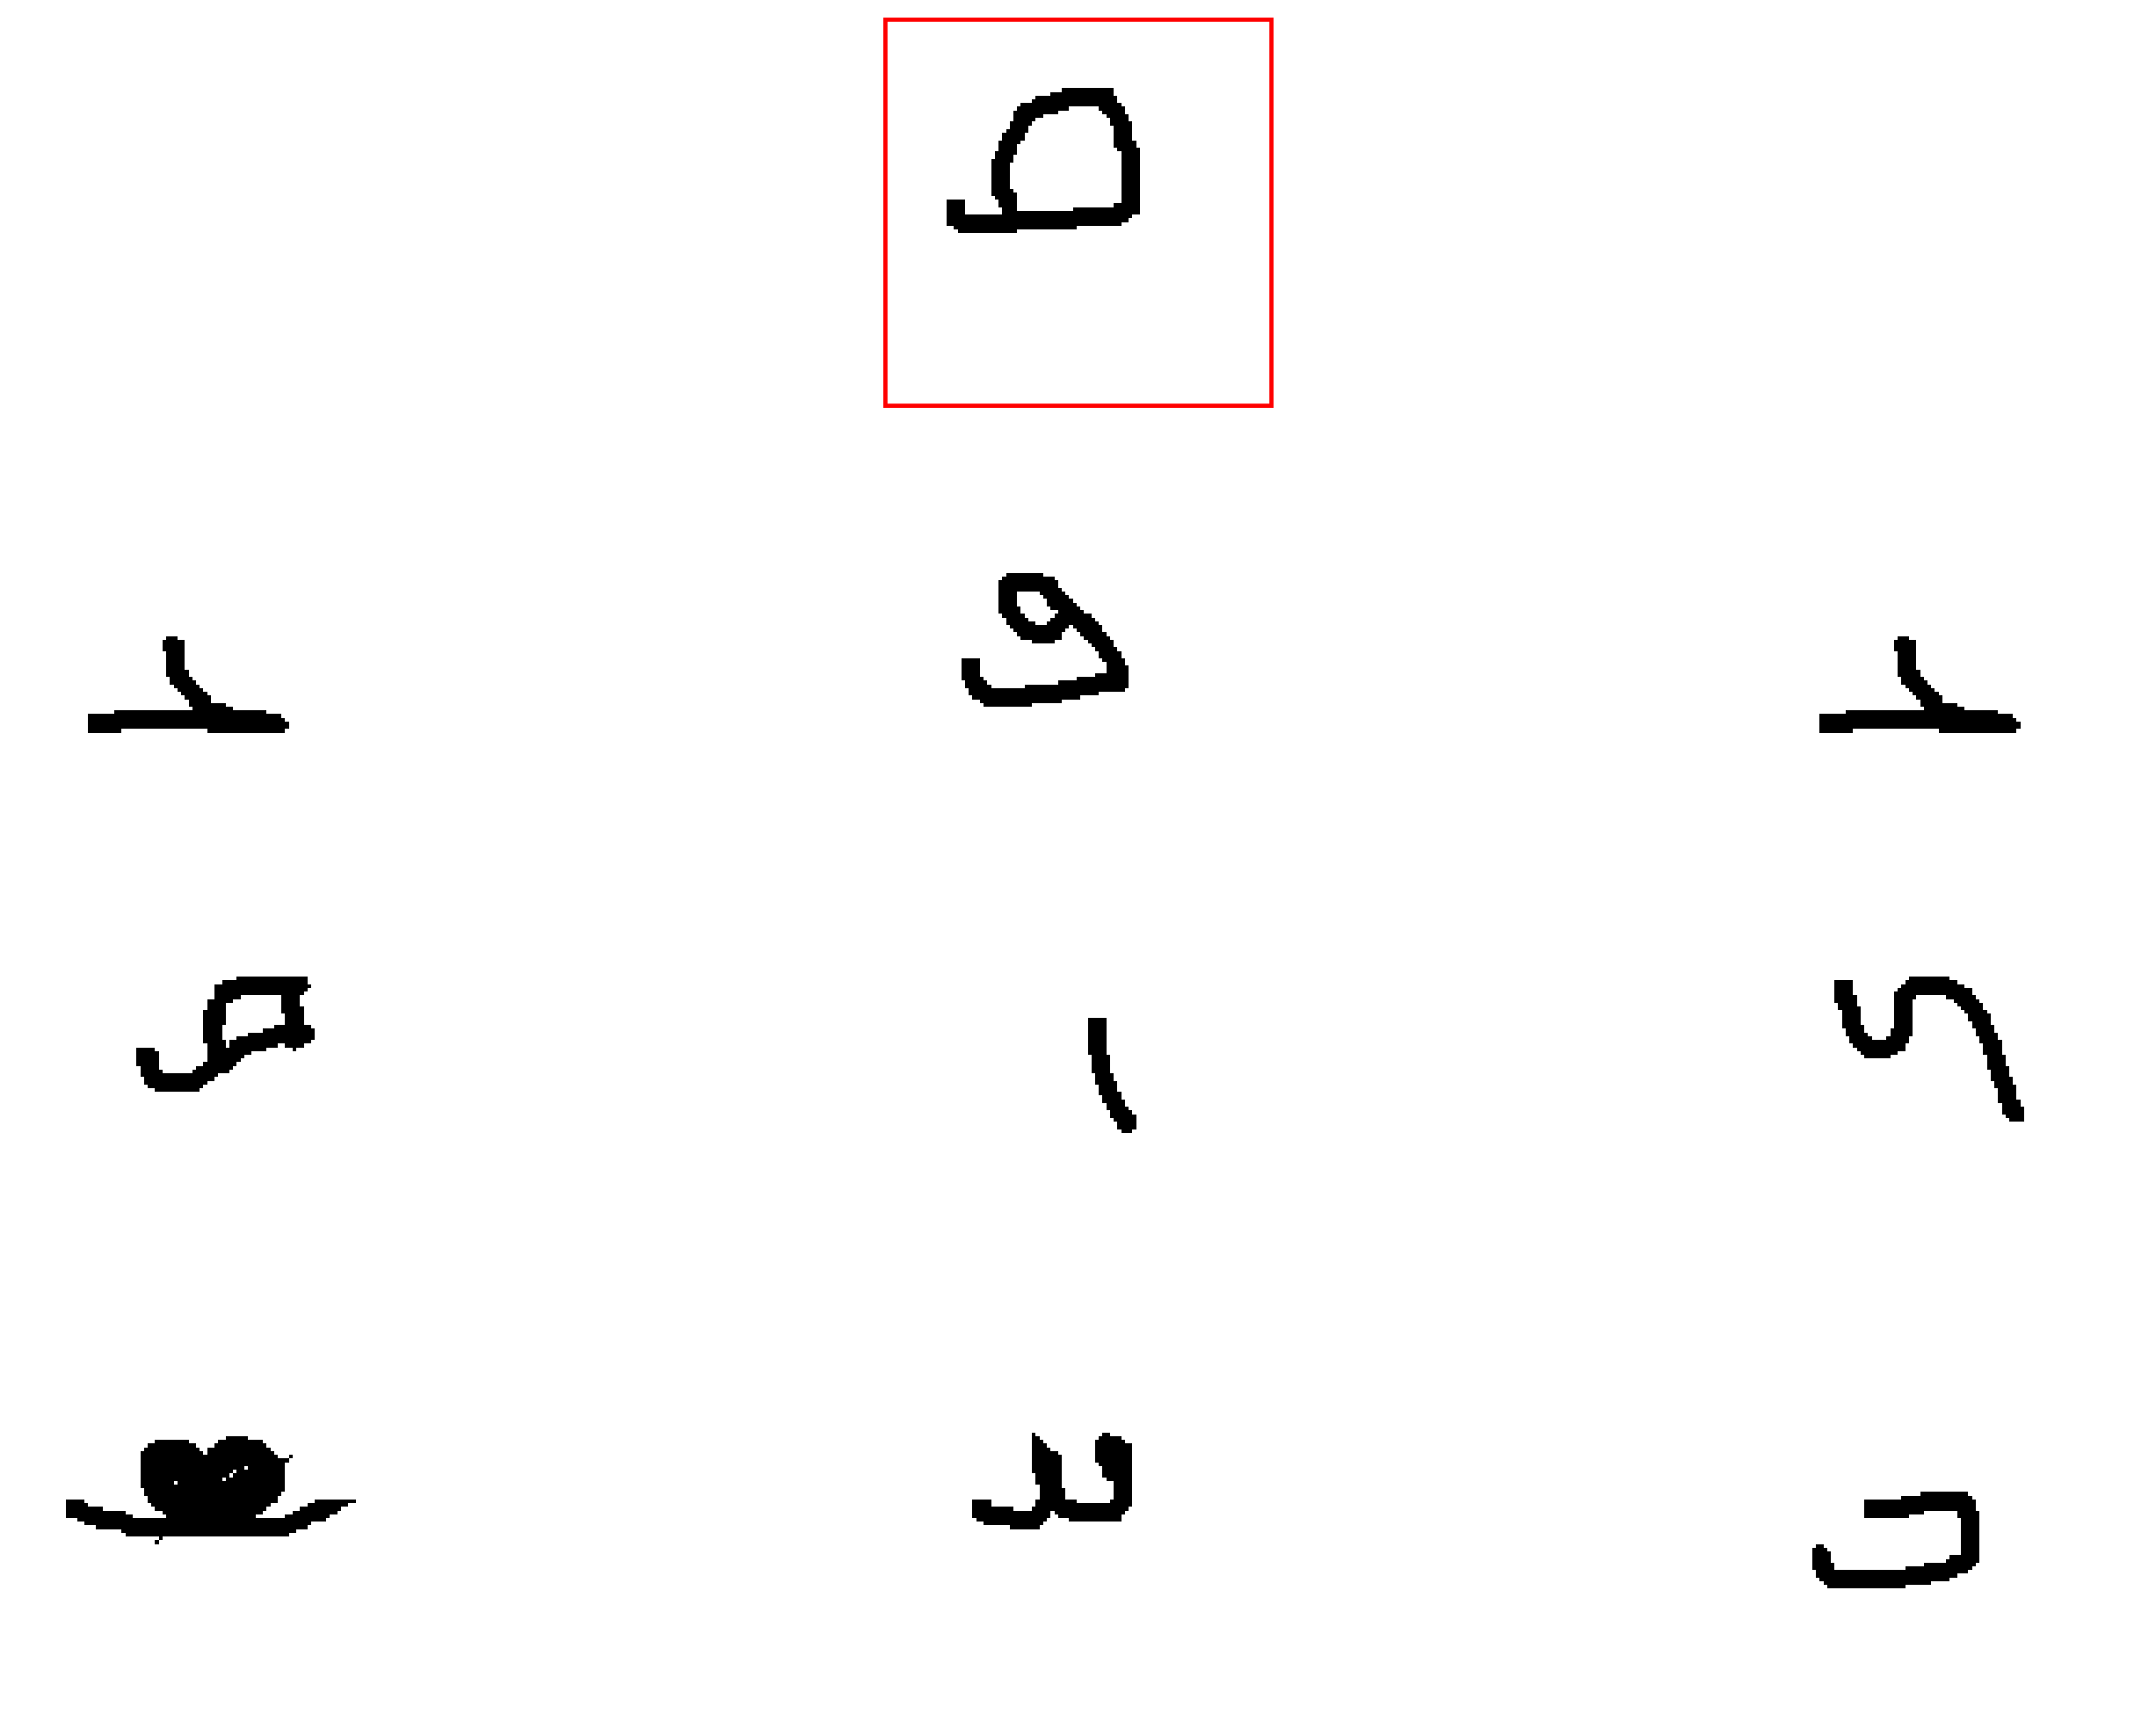

In [9]:
# Paths
base_path = "data/omniglot-py/images_background"

# Running the trial
run_trial(base_path, num_trials=3)

In [10]:
# Reflection activity: How do you think you, as a human, are performing a task like Omniglot?
# One-shot learning
# Segmentation
# Conditioned generation
# Unconditioned generation


In [11]:
# Activity 2

# We build a simple widget that uses the sample bottom up parsing script in example/classification/
# to build alternative bottom up parses

In [12]:
@torch.no_grad()
def model_score_fn(model, parses):
    drawings = nested_map(lambda x: splines.get_stk_from_bspline(x), parses)
    if torch.cuda.is_available():
        drawings = nested_map(lambda x: x.cuda(), drawings)
        parses = nested_map(lambda x: x.cuda(), parses)
    losses = model.losses_fn(parses, drawings, filter_small=False, denormalize=True)
    return -losses.cpu()

def collect_img_results(img_id, parses, log_probs, reverse):
    """Collects parses and log probabilities without saving to disk."""
    appendix = 'test' if reverse else 'train'
    data = {
        'img_id': img_id,
        'appendix': appendix,
        'parses': parses,
        'log_probs': log_probs,
    }
    return data

def get_base_parses_in_memory(run_id, trials_per=800, reverse=False, dry_run=False):
    print('run_id: %i' % run_id)
    print('Loading model...')
    # Correctly identify the base directory of the `gns` package
    gns_base_dir = os.path.dirname(gns.__file__)
    
    # Specify the model save directory within the `gns` package
    model_save_path = os.path.join(gns_base_dir, 'model_saves')
    
    # Initialize TypeModel 
    type_model = TypeModel().eval()

    if torch.cuda.is_available():
        type_model = type_model.cuda()
    score_fn = lambda parses: model_score_fn(type_model, parses)

    # Use the dynamically determined path
    osc_path = os.path.join(os.getcwd(), 'data/one-shot-classification')
    print('Loading classification dataset...')
    dataset = ClassificationDataset(osc_folder=osc_path)
    run = dataset.runs[run_id]
    imgs = run.test_imgs if reverse else run.train_imgs

    collected_data = []  # In-memory storage for parses and log_probs

    print('Collecting top-K parses for each train image...')
    nimg = len(imgs)
    for i in range(nimg):
        start_time = time.time()
        parses, log_probs = get_topK_parses(
            imgs[i], k=5, score_fn=score_fn, configs_per=1,
            trials_per=trials_per)
        total_time = time.time() - start_time
        print(f'image {i+1}/{nimg} took {time_string(total_time)}')
        if dry_run:
            continue
        img_results = collect_img_results(i, parses, log_probs, reverse)
        collected_data.append(img_results)

    return collected_data

# Example usage
run_id = 10
trials_per = 800
reverse = False
dry_run = False

# Call the function
collected_data = get_base_parses_in_memory(run_id=run_id, trials_per=trials_per, reverse=reverse, dry_run=dry_run)

run_id: 10
Loading model...


/home/samuele/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading classification dataset...


/home/samuele/.local/lib/python3.10/site-packages/pybpl/bottomup/generate_random_parses.py:9: UserWarning: using untested python implementation of 'generate_random_walks'
  warnings.warn("using untested python implementation of "


image 1/20 took 0:00:06


/home/samuele/.local/lib/python3.10/site-packages/pybpl/bottomup/generate_random_parses.py:9: UserWarning: using untested python implementation of 'generate_random_walks'
  warnings.warn("using untested python implementation of "


image 2/20 took 0:00:09
image 3/20 took 0:00:03
image 4/20 took 0:00:05
image 5/20 took 0:00:02
image 6/20 took 0:00:35
image 7/20 took 0:00:02
image 8/20 took 0:00:06
image 9/20 took 0:00:02
image 10/20 took 0:00:38
image 11/20 took 0:00:34
image 12/20 took 0:00:04
image 13/20 took 0:00:03
image 14/20 took 0:00:04
image 15/20 took 0:00:52
image 16/20 took 0:00:02
image 17/20 took 0:00:10
image 18/20 took 0:00:41
image 19/20 took 0:00:03
image 20/20 took 0:00:07


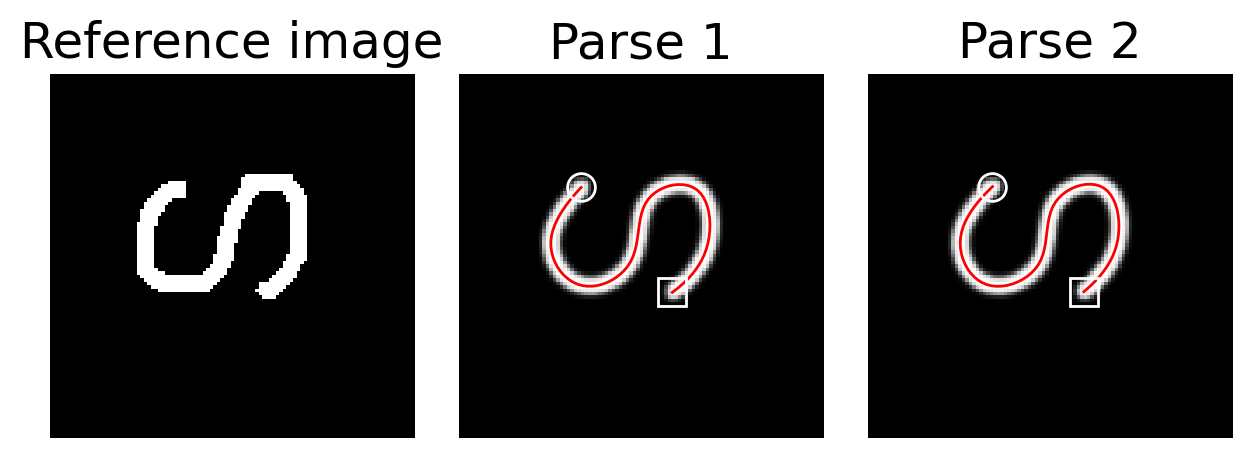

In [13]:
# Use retina mode for matplotlib
%config InlineBackend.figure_format = 'retina'

# Function to visualize parses
def visualize_parses(renderer, collected_data, item, run):
    # Load the classification labels to map test images to their corresponding training images
    with open(f'./data/one-shot-classification/all_runs/run{run+1:02}/class_labels.txt') as f:
        data = f.readlines()

    test_to_train = {}
    for line in data:
        left, right = line.split(' ')
        test_to_train[left.split('/')[-1]] = right.split('/')[-1].strip()

    plt.figure(figsize=(12.5, 2.5))
    train_im = test_to_train[f'item{item:02}.png']

    # Reference image visualization
    plt.subplot(1, 6, 1)
    plt.imshow(1 - plt.imread(f'./data/one-shot-classification/all_runs/run{run+1:02}/training/{train_im}'), cmap='gray')
    plt.title('Reference image')
    plt.axis('off')

    # Load parses from the collected data
    for img_data in collected_data:
        if img_data['img_id'] == item - 1:
            parses = img_data['parses']
            break

    r = renderer()
    # Visualization of parses
    for i, parse in enumerate(parses):
        drawings = [splines.get_stk_from_bspline(x) for x in parse]
        plt.subplot(1, 6, i+2)
        plt.imshow(r(drawings), cmap='gray')
        plt.axis('off')
        plt.title(f'Parse {i+1}')

        colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
        for i, d in enumerate(drawings):
            plt.plot(d[:, 0], -d[:, 1], colors[i], linewidth=1)
            plt.plot(d[0, 0], -d[0, 1], 'w.', markersize=20, fillstyle='none')
            plt.plot(d[-1, 0], -d[-1, 1], 'ws', markersize=10, fillstyle='none')

# Example of visualizing parses for a specific item and run
visualize_parses(DefaultRenderer, collected_data, item=9, run=10)

In [14]:
# Activity 3

# Build parts of the forward model necessary to build a differentiable renderer for a single stroke

In [15]:
# @title Parameters 
# @markdown

class Parameters:
    def __init__(self):
        # Library to use
        self.libname = 'library'
        self.set_rendering_params()
        self.set_spline_params()
        self.set_image_model_params()
        self.set_mcmc_params()
        self.set_search_params()
        
    def set_rendering_params(self):
        self.imsize = torch.Size([105, 105]) # image size

        ## ink-add parameters
        self.ink_pp = 2. # amount of ink per point
        self.ink_max_dist = 2. # distance between points to which you get full ink

        ## broadening parameters
        self.ink_ncon = 2 # number of convolutions
        self.ink_a = 0.5 # parameter 1
        self.ink_b = 6. # parameter 2
        self.broaden_mode = 'Lake' # broadening version (must be either "Lake" or "Hinton")

        ## blurring parameters
        self.fsize = 11 # convolution size for blurring

    def set_spline_params(self):
        """
        Parameters for creating a trajectory from a spline
        """
        self.spline_max_neval = 200 # maxmium number of evaluations
        self.spline_min_neval = 10 # minimum number of evaluations
        self.spline_grain = 1.5 # 1 trajectory point for every this many units pixel distance

    def set_image_model_params(self):
        """
        Max/min noise parameters for image model
        """
        self.max_blur_sigma = torch.tensor(16, dtype=torch.float) # min/max blur sigma
        self.min_blur_sigma = torch.tensor(0.5, dtype=torch.float) # min/max blur sigma
        self.max_epsilon = torch.tensor(0.5, dtype=torch.float) # min/max pixel epsilon
        self.min_epsilon = torch.tensor(1e-4, dtype=torch.float) # min/max pixel epsilon

    def set_mcmc_params(self):
        """
        MCMC parameters
        """
        ## chain parameters
        self.mcmc_nsamp_type_chain = 200 # number of samples to take in the MCMC chain (for classif.)
        self.mcmc_nsamp_type_store = 10 # number of samples to store from this chain (for classif.)
        self.mcmc_nsamp_token_chain = 25 # for completion (we take last sample in this chain)

        ## mcmc proposal parameters
        self.mcmc_prop_gpos_sd = 1 # global position move
        self.mcmc_prop_shape_sd = 3/2 # shape move
        self.mcmc_prop_scale_sd = 0.0235 # scale move
        self.mcmc_prop_relmid_sd = 0.2168 # attach relation move
        self.mcmc_prop_relpos_mlty = 2 # multiply the sd of the standard position noise by this to propose new positions from prior

    def set_search_params(self):
        """
        Parameters of search algorithm (part of inference)
        """
        self.K = 5 # number of particles to use in search algorithm
        self.max_affine_scale_change = 2 # scale changes must be less than a factor of 2
        self.max_affine_shift_change = 50 # shift changes must less than this  

In [16]:
# @title Broaden and Blur 
# @markdown

class BroadenAndBlur(nn.Module):
    def __init__(self, blur_sigma=0.5, epsilon=0., blur_fsize=None, PM=None):
        super().__init__()
        if PM is None:
            PM = Parameters()
        if blur_fsize is None:
            blur_fsize = PM.fsize
        assert blur_fsize % 2 == 1, 'blur conv filter size must be odd'
        self.register_buffer('H_broaden', broaden_filter(PM.ink_a, PM.ink_b))
        self.register_buffer('H_blur', blur_filter(blur_fsize, blur_sigma))
        self.nbroad = PM.ink_ncon
        self.blur_pad = blur_fsize//2
        self.blur_sigma = blur_sigma
        self.blur_fsize = blur_fsize
        self.epsilon = epsilon

    @property
    def device(self):
        return self.H_broaden.device

    @property
    def is_cuda(self):
        return self.H_broaden.is_cuda

    def forward(self, x, blur_sigma=None, epsilon=None):
        """
        Parameters
        ----------
        x : torch.Tensor
            [n,H,W] pre-conv image probabilities
        blur_sigma : float | None
            amount of blur. 'None' means use value from __init__ call

        Returns
        -------
        x : torch.Tensor
            [n,H,W] post-conv image probabilities
        """
        if self.is_cuda:
            x = x.cuda()

        if blur_sigma is None:
            H_blur = self.H_blur
            blur_sigma = self.blur_sigma
        else:
            blur_sigma = check_float_tesnor(blur_sigma, self.device)
            H_blur = blur_filter(self.blur_fsize, blur_sigma, device=self.device)

        if epsilon is None:
            epsilon = self.epsilon
        else:
            epsilon = check_float_tesnor(epsilon, self.device)

        # unsqueeze
        x = x.unsqueeze(1)
        # apply broaden
        for i in range(self.nbroad):
            x = F.conv2d(x, self.H_broaden, padding=1)
        x = F.hardtanh(x, 0., 1.)
        # return if no blur
        if blur_sigma == 0:
            x = x.squeeze(1)
            return x
        # apply blur
        for i in range(2):
            x = F.conv2d(x, H_blur, padding=self.blur_pad)
        x = F.hardtanh(x, 0., 1.)
        # apply pixel noise
        if epsilon > 0:
            x = (1-epsilon)*x + epsilon*(1-x)
        # squeeze
        x = x.squeeze(1)

        return x

In [17]:
# @title Hidden methods for Renderer and Painter 
# @markdown

def cuda(self, device=None):
    self.painter = self.painter.cpu()
    self.broaden_and_blur = self.broaden_and_blur.cuda(device)
    return self

def forward_partial_r(self, drawing, blur_sigma=None, epsilon=None, concat=False):
    """
    In this version, we include all partial canvas renders in addition
    to the final renders
    """
    if isinstance(drawing[0], list):
        pimgs = [self.painter.forward_partial(d) for d in drawing]
        lengths = [len(p) for p in pimgs]
        pimgs = torch.cat(pimgs)
        pimgs = self.broaden_and_blur(pimgs, blur_sigma, epsilon)
        if concat:
            return pimgs
        pimgs = torch.split(pimgs, lengths, 0)
        return list(pimgs)
    else:
        pimgs = self.painter.forward_partial(drawing)
        pimgs = self.broaden_and_blur(pimgs, blur_sigma, epsilon)
        return pimgs

def forward_partial_p(self, drawing):
    """
    In this version, we include all partial canvas renders in addition
    to the final renders
    """
    assert not self.is_cuda
    drawing = drawings_to_cpu(drawing)
    ns = len(drawing)
    pimgs = torch.zeros(ns+1, *self.imsize)
    canvas = torch.zeros(*self.imsize)
    for i, stk in enumerate(drawing):
        canvas, _ = self.add_stroke(canvas, stk)
        pimgs[i+1] = canvas
    return pimgs

def check_bounds(self, myt):
    xt = myt[:,0]
    yt = myt[:,1]
    x_out = (torch.floor(xt) < 0) | (torch.ceil(xt) >= self.imsize[0])
    y_out = (torch.floor(yt) < 0) | (torch.ceil(yt) >= self.imsize[1])
    out = x_out | y_out
    return out

def seqadd(self, D, lind_x, lind_y, inkval):
    lind = self.index_mat[lind_x.long(), lind_y.long()]
    D = D.view(-1)
    D = D.scatter_add(0, lind, inkval)
    D = D.view(self.imsize)
    return D

In [20]:
class Renderer(nn.Module):
    def __init__(self, blur_sigma=0.5, epsilon=0., blur_fsize=None, PM=None):
        super().__init__()
        if PM is None:
            PM = Parameters()

        self.painter = Painter(PM)
        self.broaden_and_blur = BroadenAndBlur(blur_sigma, epsilon, blur_fsize, PM)

    def forward(self, drawings, blur_sigma=None, epsilon=None):
        """
        Render each drawing by converting the drawing to image ink
        and then applying broaden & blur filters

        Parameters
        ----------
        drawings : list[list[torch.Tensor]] | list[torch.Tensor]
            Input drawings. Each drawing is a list of tensors
        blur_sigma : float | None
            Sigma parameter for blurring. Only used for adaptive blurring.
            Default 'None' means use the blur_sigma from __init__() call

        Returns
        -------
        pimgs : torch.Tensor
            [n,H,W] Pre-conv image probabilities
        """

        #################################################
        ## TODO for students: fill in the missing variables ##
        # Fill out function and remove
        raise NotImplementedError("Student exercise: fill in the missing variables")
        #################################################
        
        # draw the strokes (this part on cpu)
        if not isinstance(drawings[0], list):
            single = True
            drawings = [drawings]
        else:
            single = False

        pimgs = ...
        pimgs = self.broaden_and_blur(pimgs, blur_sigma, epsilon) # (n,H,W)

        if single:
            pimgs = pimgs[0]

        return pimgs

class Painter(nn.Module):
    def __init__(self, PM=None):
        super().__init__()
        if PM is None:
            PM = Parameters()
        self.ink_pp = PM.ink_pp
        self.ink_max_dist = PM.ink_max_dist
        self.register_buffer('index_mat',
                             torch.arange(PM.imsize[0]*PM.imsize[1]).view(PM.imsize))
        self.register_buffer('space_flip', torch.tensor([-1.,1.]))
        self.imsize = PM.imsize

    @property
    def device(self):
        return self.index_mat.device

    @property
    def is_cuda(self):
        return self.index_mat.is_cuda

    def space_motor_to_img(self, stk):
        return torch.flip(stk, dims=[-1])*self.space_flip

    def add_stroke(self, pimg, stk):
        stk = self.space_motor_to_img(stk)
        # reduce trajectory to only those points that are in bounds
        out = self.check_bounds(stk) # boolean; shape (neval,)
        ink_off_page = out.any()
        if out.all():
            return pimg, ink_off_page
        stk = stk[~out]

        # compute distance between each trajectory point and the next one
        if stk.shape[0] == 1:
            myink = stk.new_tensor(self.ink_pp)
        else:
            dist = torch.norm(stk[1:] - stk[:-1], dim=-1) # shape (k,)
            dist = dist.clamp(None, self.ink_max_dist)
            dist = torch.cat([dist[:1], dist])
            myink = (self.ink_pp/self.ink_max_dist)*dist # shape (k,)

        # make sure we have the minimum amount of ink, if a particular
        # trajectory is very small
        sumink = torch.sum(myink)
        if sumink < 2.22e-6:
            nink = myink.shape[0]
            myink = (self.ink_pp/nink)*torch.ones_like(myink)
        elif sumink < self.ink_pp:
            myink = (self.ink_pp/sumink)*myink
        assert torch.sum(myink) > (self.ink_pp - 1e-4)

        # share ink with the neighboring 4 pixels
        x = stk[:,0]
        y = stk[:,1]
        xfloor = torch.floor(x).detach()
        yfloor = torch.floor(y).detach()
        xceil = torch.ceil(x).detach()
        yceil = torch.ceil(y).detach()
        x_c_ratio = x - xfloor
        y_c_ratio = y - yfloor
        x_f_ratio = 1 - x_c_ratio
        y_f_ratio = 1 - y_c_ratio
        lind_x = torch.cat([xfloor, xceil, xfloor, xceil])
        lind_y = torch.cat([yfloor, yfloor, yceil, yceil])
        inkval = torch.cat([
            myink*x_f_ratio*y_f_ratio,
            myink*x_c_ratio*y_f_ratio,
            myink*x_f_ratio*y_c_ratio,
            myink*x_c_ratio*y_c_ratio
        ])
        # paint the image
        pimg = self.seqadd(pimg, lind_x, lind_y, inkval)
        return pimg, ink_off_page

    def draw(self, pimg, strokes):
        for stk in strokes:
            pimg, _ = ...
        return pimg

    def forward(self, drawings):
        assert not self.is_cuda
        drawings = drawings_to_cpu(drawings)
        n = len(drawings)
        pimgs = torch.zeros(n, *self.imsize)
        for i in range(n):
            pimgs[i] = ...
        return pimgs

# Uncomment the code below to test your function
# Example of visualizing parses for a specific item and run

# Add hidden methods (otherwise code would have been too long)
#Renderer.cuda = cuda
#Renderer.forward_partial_r = forward_partial_r
#Painter.forward_partial_p = forward_partial_p
#Painter.check_bounds = check_bounds
#Painter.seq_add = seq_add

# Now create instances of Renderer and Painter 
#renderer_instance = Renderer()
#painter_instance = Painter()
        
#visualize_parses(Renderer, collected_data, item=9, run=10)

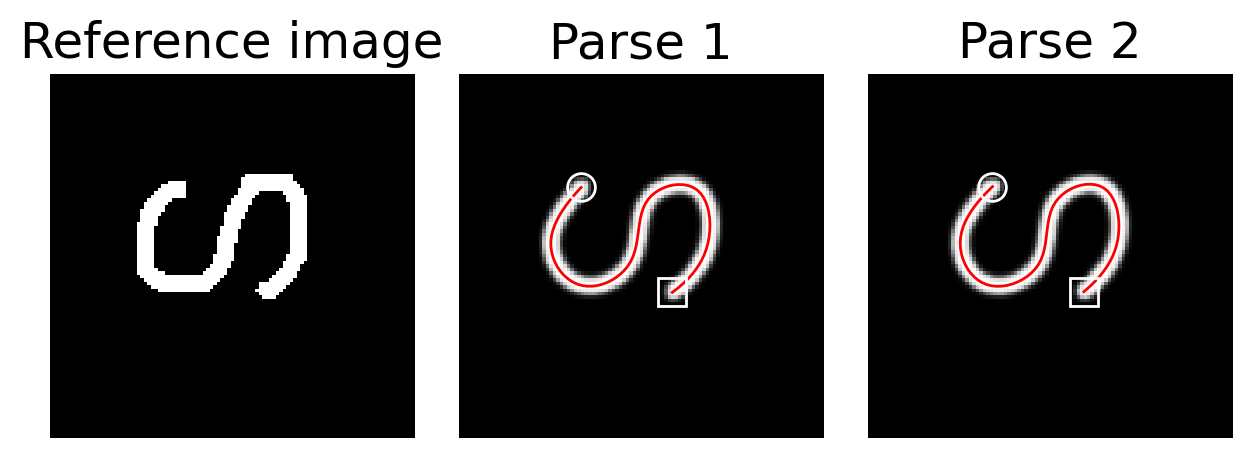

In [22]:
#to remove solution

class Renderer(nn.Module):
    def __init__(self, blur_sigma=0.5, epsilon=0., blur_fsize=None, PM=None):
        super().__init__()
        if PM is None:
            PM = Parameters()

        self.painter = Painter(PM)
        self.broaden_and_blur = BroadenAndBlur(blur_sigma, epsilon, blur_fsize, PM)

    def forward(self, drawings, blur_sigma=None, epsilon=None):
        """
        Render each drawing by converting the drawing to image ink
        and then applying broaden & blur filters

        Parameters
        ----------
        drawings : list[list[torch.Tensor]] | list[torch.Tensor]
            Input drawings. Each drawing is a list of tensors
        blur_sigma : float | None
            Sigma parameter for blurring. Only used for adaptive blurring.
            Default 'None' means use the blur_sigma from __init__() call

        Returns
        -------
        pimgs : torch.Tensor
            [n,H,W] Pre-conv image probabilities
        """
        # draw the strokes (this part on cpu)
        if not isinstance(drawings[0], list):
            single = True
            drawings = [drawings]
        else:
            single = False

        pimgs = self.painter(drawings)
        pimgs = self.broaden_and_blur(pimgs, blur_sigma, epsilon) # (n,H,W)

        if single:
            pimgs = pimgs[0]

        return pimgs

class Painter(nn.Module):
    def __init__(self, PM=None):
        super().__init__()
        if PM is None:
            PM = Parameters()
        self.ink_pp = PM.ink_pp
        self.ink_max_dist = PM.ink_max_dist
        self.register_buffer('index_mat',
                             torch.arange(PM.imsize[0]*PM.imsize[1]).view(PM.imsize))
        self.register_buffer('space_flip', torch.tensor([-1.,1.]))
        self.imsize = PM.imsize

    @property
    def device(self):
        return self.index_mat.device

    @property
    def is_cuda(self):
        return self.index_mat.is_cuda

    def space_motor_to_img(self, stk):
        return torch.flip(stk, dims=[-1])*self.space_flip

    def add_stroke(self, pimg, stk):
        stk = self.space_motor_to_img(stk)
        # reduce trajectory to only those points that are in bounds
        out = self.check_bounds(stk) # boolean; shape (neval,)
        ink_off_page = out.any()
        if out.all():
            return pimg, ink_off_page
        stk = stk[~out]

        # compute distance between each trajectory point and the next one
        if stk.shape[0] == 1:
            myink = stk.new_tensor(self.ink_pp)
        else:
            dist = torch.norm(stk[1:] - stk[:-1], dim=-1) # shape (k,)
            dist = dist.clamp(None, self.ink_max_dist)
            dist = torch.cat([dist[:1], dist])
            myink = (self.ink_pp/self.ink_max_dist)*dist # shape (k,)

        # make sure we have the minimum amount of ink, if a particular
        # trajectory is very small
        sumink = torch.sum(myink)
        if sumink < 2.22e-6:
            nink = myink.shape[0]
            myink = (self.ink_pp/nink)*torch.ones_like(myink)
        elif sumink < self.ink_pp:
            myink = (self.ink_pp/sumink)*myink
        assert torch.sum(myink) > (self.ink_pp - 1e-4)

        # share ink with the neighboring 4 pixels
        x = stk[:,0]
        y = stk[:,1]
        xfloor = torch.floor(x).detach()
        yfloor = torch.floor(y).detach()
        xceil = torch.ceil(x).detach()
        yceil = torch.ceil(y).detach()
        x_c_ratio = x - xfloor
        y_c_ratio = y - yfloor
        x_f_ratio = 1 - x_c_ratio
        y_f_ratio = 1 - y_c_ratio
        lind_x = torch.cat([xfloor, xceil, xfloor, xceil])
        lind_y = torch.cat([yfloor, yfloor, yceil, yceil])
        inkval = torch.cat([
            myink*x_f_ratio*y_f_ratio,
            myink*x_c_ratio*y_f_ratio,
            myink*x_f_ratio*y_c_ratio,
            myink*x_c_ratio*y_c_ratio
        ])
        # paint the image
        pimg = self.seqadd(pimg, lind_x, lind_y, inkval)
        return pimg, ink_off_page

    def draw(self, pimg, strokes):
        for stk in strokes:
            pimg, _ = self.add_stroke(pimg, stk)
        return pimg

    def forward(self, drawings):
        assert not self.is_cuda
        drawings = drawings_to_cpu(drawings)
        n = len(drawings)
        pimgs = torch.zeros(n, *self.imsize)
        for i in range(n):
            pimgs[i] = self.draw(pimgs[i], drawings[i])
        return pimgs

# Uncomment the code below to test your function
# Example of visualizing parses for a specific item and run

# Add hidden methods (otherwise code would have been too long)
#Renderer.cuda = cuda
#Renderer.forward_partial_r = forward_partial_r
#Painter.forward_partial_p = forward_partial_p
#Painter.check_bounds = check_bounds
#Painter.seqadd = seqadd

# Now create instances of Renderer and Painter 
#renderer_instance = Renderer()
#painter_instance = Painter()
        
#visualize_parses(Renderer, collected_data, item=9, run=10)